# Medical Diagnosis of retina scans using Computer Vision 

Diabetic retinopathy affects blood vessels in the light-sensitive tissue called the retina that lines the back of the eye. It is the most common cause of vision loss among people with diabetes and the leading cause of vision impairment and blindness among working-age adults. It don't have any earaly symtoms. As of now, Retena photography is a way to detect the stage of Blindness. Automating it with ml, will help a lot in health domain.

## Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are at least 5 things to spot on.

![](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

## Signs and Symptoms

Diabetics should seek treatment right away if they experience:

- Blurry, cloudy vision
- Floaters or dark spots in their field of vision
- Loss of central vision, especially when reading and driving
- Trouble driving or seeing at night
- Fluctuating vision
- Compromised color vision
- Vision loss

## Risk Factors

You are at high risk for developing diabetic retinopathy if you have type 1 or type 2 diabetes and:

- Have poorly controlled diabetes
- Have high blood pressure
- Have high cholesterol
- Are Hispanic or African American

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.metrics import cohen_kappa_score
from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD,Adagrad,Adadelta
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")
gc.enable()

Using TensorFlow backend.


## Loading Data

In [0]:
dir_path = "drive/My Drive/train_images"
df_train = pd.read_csv(os.path.join(dir_path, "Full_data_19_15.csv"))
NUM_CLASSES = df_train['diagnosis'].nunique()

print("Training set has {} samples and {} classes.".format(df_train.shape[0], NUM_CLASSES))

Training set has 6936 samples and 5 classes.


In [0]:
for image_file in tqdm(df_train['id_code']):
  file_path = os.path.join(dir_path, image_file)
  if os.path.exists(file_path):
    pass
  else:
    print ("Missing file: "+ image_file)
    df_train.drop(df_train.loc[df_train['id_code']==image_file].index, inplace=True)

100%|██████████| 6936/6936 [00:04<00:00, 1602.79it/s]


In [0]:
df_train.shape

(6936, 2)

## Data Glance

Lets have a look at the dataset that we are working with.

CPU times: user 3.38 s, sys: 149 ms, total: 3.52 s
Wall time: 3.25 s


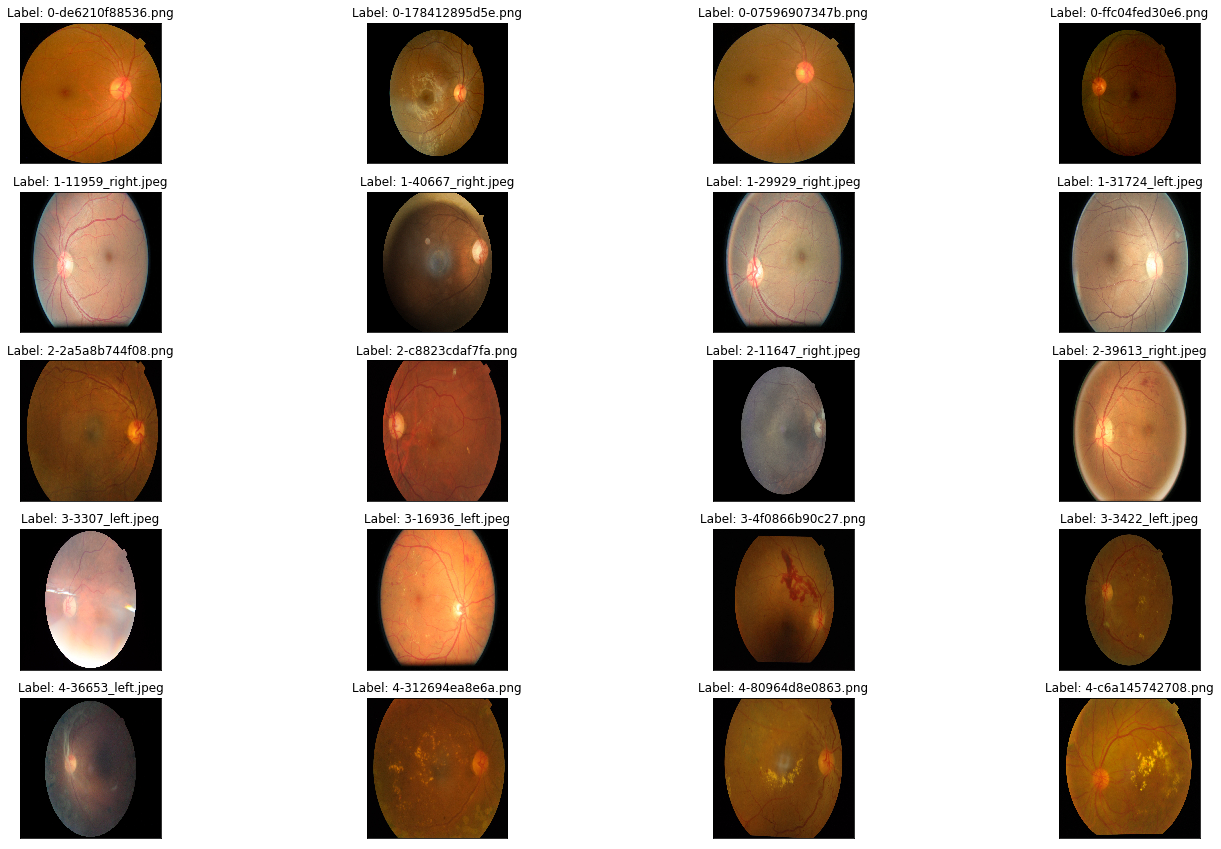

In [0]:
%%time
fig = plt.figure(figsize=(30, 15))
for class_id in sorted(df_train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(4, random_state=7).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"drive/My Drive/train_images/{row['id_code']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1200, 1200))

        plt.imshow(image)
        ax.set_title('Label: %d-%s' % (class_id, row['id_code']) )

Lets try to gray scale the images and see if we can highlight some explicit features and reduce the inconsistency due to different coloring condition of the images.

CPU times: user 2.64 s, sys: 56 ms, total: 2.69 s
Wall time: 2.59 s


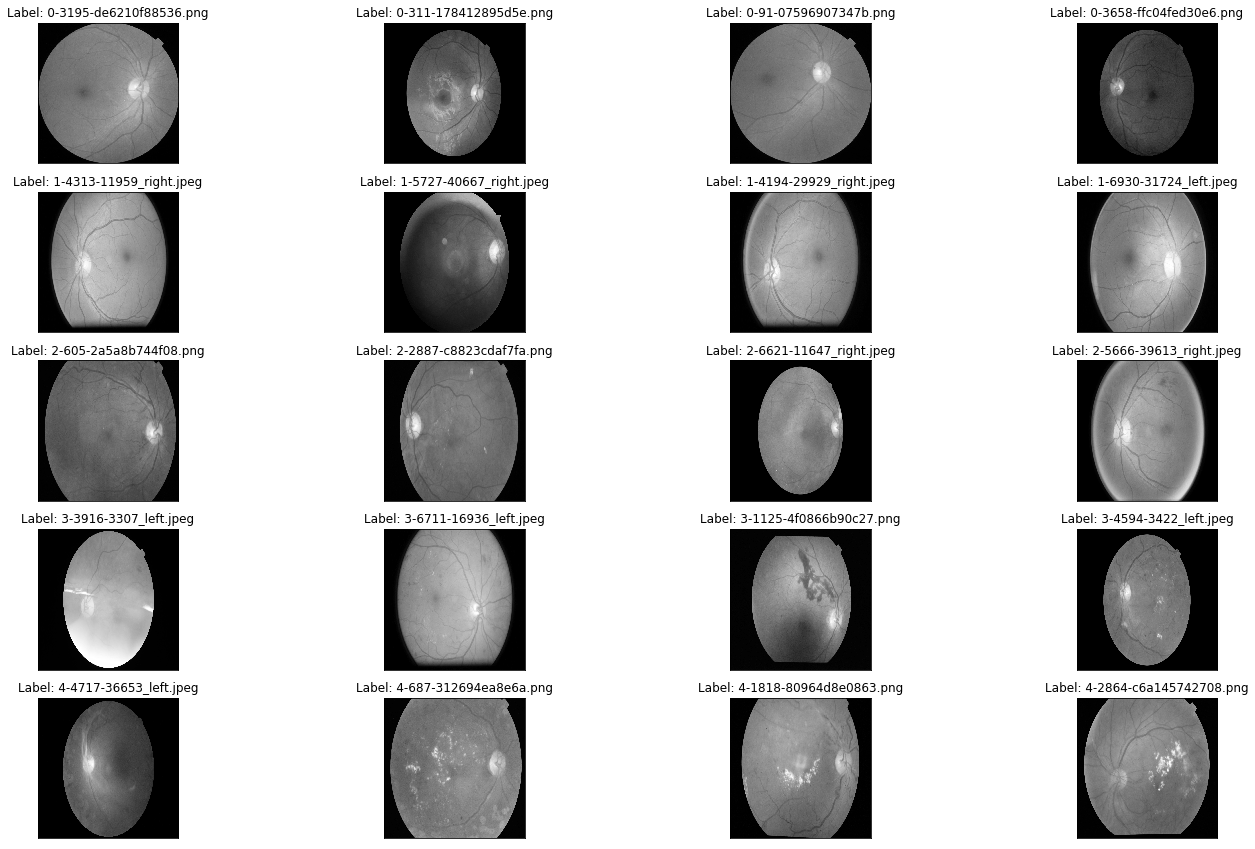

In [0]:
%%time
fig = plt.figure(figsize=(30, 15))
for class_id in sorted(df_train['diagnosis'].unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(4, random_state=7).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"drive/My Drive/train_images/{row['id_code']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (1200, 1200))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

## General Observations

- The dataset is heavily imbalanced across 5 classes , hence bucketing the samples into 2 classes
- Image shape is not in standard across the dataset, we need to resize the images before processing.
- Some images are very small, and some are very large they are not in same standard.
- Some images have large uninformative areas which might need additional cropping.
- Some image are light and some are very dark.

In [0]:
%%time
import cv2
from PIL import Image
import numpy as np
def load_image(fname):
      try:
        path ="drive/My Drive/train_images/"+fname
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))
        return image
      except:
        print("Missing file: "+path)

if os.path.exists(os.path.join("drive/My Drive/train_images", "file.npy")):
  x = np.load(os.path.join("drive/My Drive/train_images", "file.npy"),allow_pickle=True)
  print("Data matrix loaded in memory")
else:
  x = np.array([load_image(fname) for fname in tqdm(df_train['id_code'])])
  x.dump('drive/My Drive/train_images/file.npy')
  print("Data matrix saved to disk")
y=np.array(df_train['diagnosis'])

Data matrix loaded in memory
CPU times: user 2.61 s, sys: 2.84 s, total: 5.45 s
Wall time: 29.2 s


First lets get started with multi class clasification , we know that we have 5 classes in our dataset and the dataset itself is very heavily skewed.

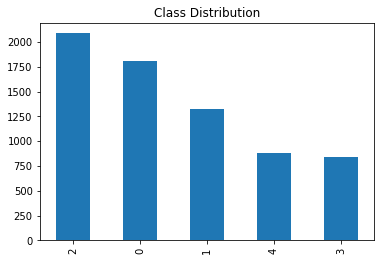

In [0]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Class Distribution');
plt.show()

In [0]:
from keras import backend as K
# def cohen_kappa(y_true, y_pred):
#     #y_true=y_true.sum(axis=1) - 1
#     #y_true=K.sum(y_true, axis=1, keepdims=False).numpy()-1
#     #y_true=y_true.sum(axis=1) - 1
#     #y_pred = y_pred.astype(int).sum(axis=1) - 1
#     #y_pred=K.sum(y_pred, axis=1, keepdims=False).numpy()-1
#     cohen_score=cohen_kappa_score(y_true, y_pred, weights='quadratic')
#     K.get_session().run(tf.local_variables_initializer())
#     return cohen_score

# def _cohen_kappa(y_true, y_pred, num_classes=5, weights='quadratic', metrics_collections=None, updates_collections=None, name=None):
#    K.get_session().run(tf.local_variables_initializer())
#    y_true=tf.math.argmax(y_true, axis=1)
#    y_pred=tf.math.argmax(y_pred, axis=1)
#    kappa, update_op = tf.contrib.metrics.cohen_kappa(y_true, y_pred, num_classes, weights, metrics_collections, updates_collections, name)
#    with tf.control_dependencies([update_op]):
#       kappa = tf.identity(kappa)
#    return kappa


def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [0]:
import warnings
warnings.filterwarnings('ignore')

def my_custom_model_multi_class_classification():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[300, 300, 3], activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())



  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=1000, activation=relu))
  model.add(Dropout(rate=0.3))
  model.add(BatchNormalization())

  model.add(Dense(units=500, activation=relu))
  model.add(Dropout(rate=0.3))

  model.add(Dense(units=200, activation=relu))
  model.add(Dropout(rate=0.3))

  model.add(Dense(5, activation='softmax'))
  return model


model=my_custom_model_multi_class_classification()


model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',auc,recall_m, precision_m, f1_m])

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# # Reducing the Learning Rate if result is not improving. 
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
#                               verbose=1)

y_new=keras.utils.to_categorical(df_train['diagnosis'])

history=model.fit(x[:3663, :,:,:], 
          y_new[:3663], 
          epochs=30,
          batch_size=32,
          callbacks=[early_stop, reduce_lr],
          validation_split=0.15, 
          shuffle=True,
          use_multiprocessing=True,
          verbose=1)

predictions=model.predict_classes(x[:3663, :,:,:])
cohen_score=cohen_kappa_score(df_train['diagnosis'][:3663], predictions, weights='quadratic')
print("The model finished training with kappa score : "+ str(cohen_score))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 148, 148, 32)      4128      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 73, 73, 32)       

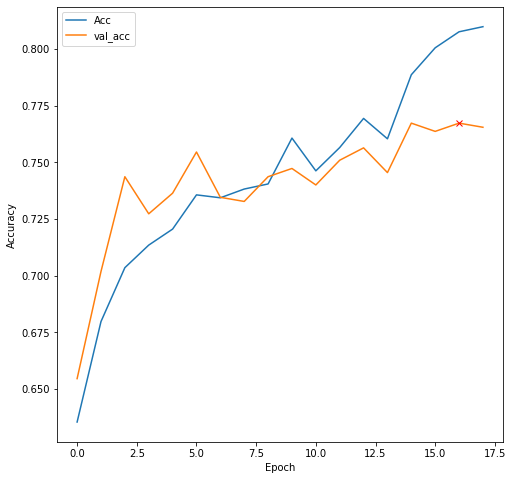

In [0]:
plt.figure(figsize=(8, 8))
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

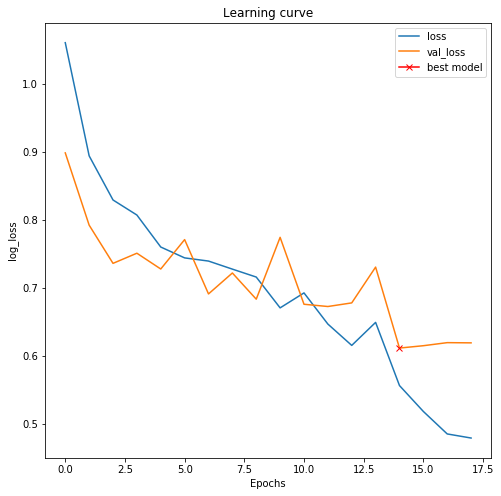

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

So we get the best model with a Training accuracy of ~80% and test accuracy of ~76%.

Lets see if we can use transfer learning and achieve some gains.

In [0]:
from keras.applications import DenseNet121
def create_densenet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=input_tensor)
    #base_model.load_weights('/kaggle/working/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_densenet= Model(input_tensor, output_layer)
    return model_densenet


model_densenet = create_densenet(300, 3, 5)
for layers in model_densenet.layers:
    layers.trainable = True


optimizer=Adam()
model_densenet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy',auc,recall_m, precision_m, f1_m])

gc.collect()
y_new=keras.utils.to_categorical(df_train['diagnosis'])

history=model_densenet.fit(x[:3663, :,:,:], 
          y_new[:3663], 
          epochs=30,
          batch_size=32,
          callbacks=[early_stop, reduce_lr],
          validation_split=0.20, 
          shuffle=True,
          use_multiprocessing=True,
          verbose=1)

predictions=np.argmax(model_densenet.predict(x[:3663, :,:,:]), axis=1)
cohen_score=cohen_kappa_score(df_train['diagnosis'][:3663], predictions, weights='quadratic')
print("The model finished training with kappa score : "+ str(cohen_score))

Train on 2930 samples, validate on 733 samples
Epoch 1/30
2930/2930 [==============================] - 98s 34ms/step - loss: 1.4135 - acc: 0.6375 - auc: 0.8272 - recall_m: 0.6133 - precision_m: 0.6647 - f1_m: 0.6373 - val_loss: 2.5471 - val_acc: 0.7531 - val_auc: 0.8664 - val_recall_m: 0.7531 - val_precision_m: 0.7552 - val_f1_m: 0.7541
Epoch 2/30
2930/2930 [==============================] - 44s 15ms/step - loss: 0.9098 - acc: 0.7167 - auc: 0.8786 - recall_m: 0.6792 - precision_m: 0.7480 - f1_m: 0.7114 - val_loss: 0.9379 - val_acc: 0.7190 - val_auc: 0.8910 - val_recall_m: 0.7149 - val_precision_m: 0.7283 - val_f1_m: 0.7213
Epoch 3/30
2930/2930 [==============================] - 44s 15ms/step - loss: 0.7225 - acc: 0.7546 - auc: 0.9002 - recall_m: 0.7280 - precision_m: 0.7847 - f1_m: 0.7549 - val_loss: 0.8260 - val_acc: 0.7749 - val_auc: 0.9077 - val_recall_m: 0.7517 - val_precision_m: 0.7880 - val_f1_m: 0.7692
Epoch 4/30
2930/2930 [==============================] - 44s 15ms/step - loss:

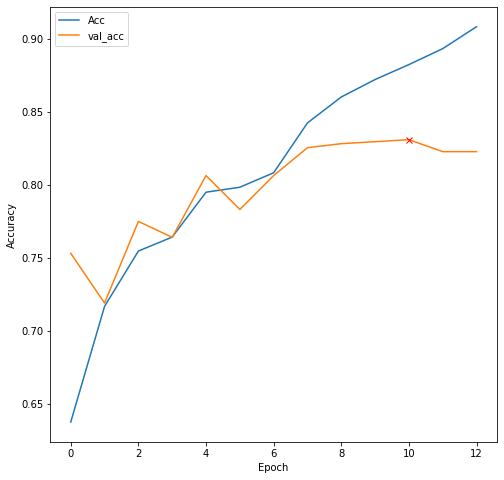

In [0]:
plt.figure(figsize=(8, 8))
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

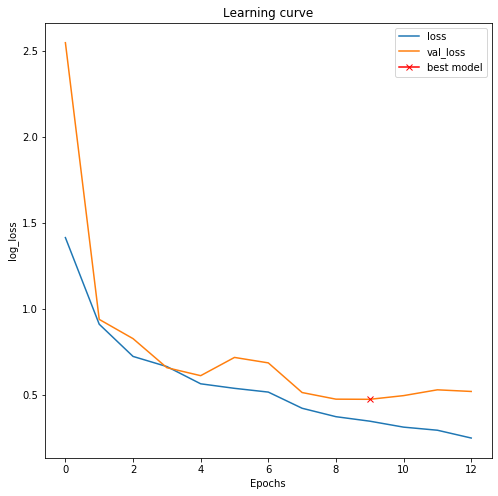

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

 Applying transfer learning on Inception model.

In [0]:
from keras.applications import InceptionResNetV2
def create_Inception(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)
    #base_model.load_weights('/kaggle/working/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_Inception= Model(input_tensor, output_layer)
    return model_Inception


model_Inception = create_Inception(300, 3, 5)
for layers in model_Inception.layers:
    layers.trainable = True


optimizer=Adam()
model_Inception.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy',auc,recall_m, precision_m, f1_m])

gc.collect()
y_new=keras.utils.to_categorical(df_train['diagnosis'])

history=model_Inception.fit(x[:3663, :,:,:], 
          y_new[:3663], 
          epochs=30,
          batch_size=32,
          callbacks=[early_stop, reduce_lr],
          validation_split=0.20, 
          shuffle=True,
          use_multiprocessing=True,
          verbose=1)

predictions=np.argmax(model_Inception.predict(x[:3663, :,:,:]), axis=1)
cohen_score=cohen_kappa_score(df_train['diagnosis'][:3663], predictions, weights='quadratic')
print("The model finished training with kappa score : "+ str(cohen_score))

Train on 2930 samples, validate on 733 samples
Epoch 1/30
2930/2930 [==============================] - 156s 53ms/step - loss: 1.2117 - acc: 0.6648 - auc: 0.8374 - recall_m: 0.6399 - precision_m: 0.6874 - f1_m: 0.6624 - val_loss: 2.7271 - val_acc: 0.6139 - val_auc: 0.8822 - val_recall_m: 0.6098 - val_precision_m: 0.6364 - val_f1_m: 0.6225
Epoch 2/30
2930/2930 [==============================] - 70s 24ms/step - loss: 0.7763 - acc: 0.7570 - auc: 0.8914 - recall_m: 0.7331 - precision_m: 0.7820 - f1_m: 0.7563 - val_loss: 0.8917 - val_acc: 0.7872 - val_auc: 0.9057 - val_recall_m: 0.7790 - val_precision_m: 0.7979 - val_f1_m: 0.7882
Epoch 3/30
2930/2930 [==============================] - 70s 24ms/step - loss: 0.6493 - acc: 0.7802 - auc: 0.9149 - recall_m: 0.7567 - precision_m: 0.8066 - f1_m: 0.7805 - val_loss: 0.7536 - val_acc: 0.7681 - val_auc: 0.9213 - val_recall_m: 0.7572 - val_precision_m: 0.7755 - val_f1_m: 0.7660
Epoch 4/30
2930/2930 [==============================] - 70s 24ms/step - loss

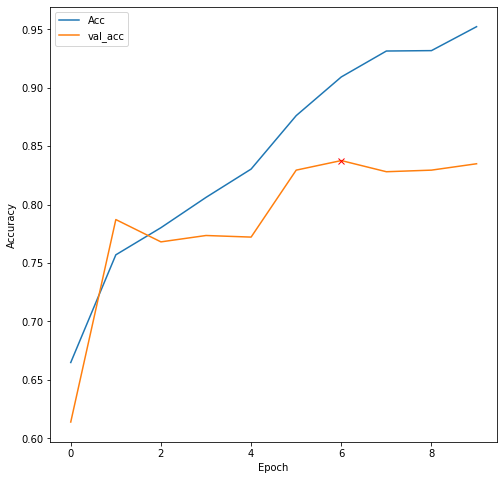

In [0]:
plt.figure(figsize=(8, 8))
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

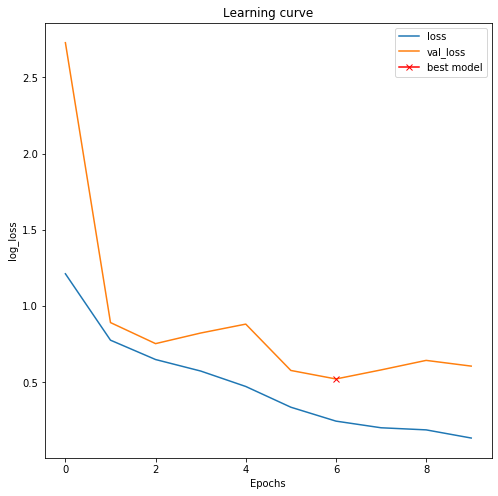

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

As anticipated the model does fairly well with a significant performance gain from transfer learning but does not have extremely high predictive power owing to the fact that the dataset is very small and imbalanced , lets take another approach and convert this into a binary classification problem by bucketing the target variable.

In [0]:
df_train['diagnosis']=df_train['diagnosis'].astype(int)
df_train.loc[df_train['diagnosis']<=1, ['diagnosis']]=0
df_train.loc[df_train['diagnosis']>=2, ['diagnosis']]=1
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,1
1,001639a390f0.png,1
2,0024cdab0c1e.png,0
3,002c21358ce6.png,0
4,005b95c28852.png,0


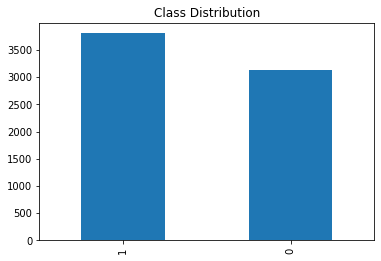

In [0]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Class Distribution');
plt.show()

In [0]:
import warnings
warnings.filterwarnings('ignore')

def my_custom_model_binary_classification():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[300, 300, 3], activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())


  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=1000, activation=relu))
  model.add(Dropout(rate=0.3))
  model.add(BatchNormalization())

  model.add(Dense(units=500, activation=relu))
  model.add(Dropout(rate=0.3))

  model.add(Dense(units=200, activation=relu))
  model.add(Dropout(rate=0.3))

  model.add(Dense(1, activation='sigmoid'))
  return model


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

y=np.array(df_train['diagnosis'])
model = my_custom_model_binary_classification()
model.summary()
# SGD does not work well, adma gives around .88 on validation, RmSProp is somewhere near 0.86
# AdaGrad is around -.87
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy',auc,recall_m, precision_m, f1_m])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 32)      4128      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 73, 73, 32)       

In [0]:
history=model.fit(x[:3663, :,:,:], 
          y[:3663], 
          epochs=30,
          batch_size=64,
          callbacks=[early_stop, reduce_lr],
          validation_split=0.20, 
          shuffle=True,
          verbose=1)

predictions=(model.predict_classes(x[:3663, :,:,:]))
cohen_score=cohen_kappa_score(y[:3663], predictions, weights='quadratic')
print("The model finished training with kappa score : "+ str(cohen_score))

Train on 2930 samples, validate on 733 samples
Epoch 1/30
2930/2930 [==============================] - 29s 10ms/step - loss: 0.4768 - acc: 0.7662 - auc: 0.8105 - recall_m: 0.7186 - precision_m: 0.7233 - f1_m: 0.7067 - val_loss: 0.3851 - val_acc: 0.8022 - val_auc: 0.8703 - val_recall_m: 0.6520 - val_precision_m: 0.8106 - val_f1_m: 0.7153
Epoch 2/30
2930/2930 [==============================] - 6s 2ms/step - loss: 0.3781 - acc: 0.8259 - auc: 0.8842 - recall_m: 0.8167 - precision_m: 0.7781 - f1_m: 0.7914 - val_loss: 0.4452 - val_acc: 0.8145 - val_auc: 0.8907 - val_recall_m: 0.5748 - val_precision_m: 0.9186 - val_f1_m: 0.7035
Epoch 3/30
2930/2930 [==============================] - 6s 2ms/step - loss: 0.3446 - acc: 0.8352 - auc: 0.8981 - recall_m: 0.8068 - precision_m: 0.8033 - f1_m: 0.7980 - val_loss: 0.2991 - val_acc: 0.8568 - val_auc: 0.9030 - val_recall_m: 0.8157 - val_precision_m: 0.8087 - val_f1_m: 0.8094
Epoch 4/30
2930/2930 [==============================] - 6s 2ms/step - loss: 0.307

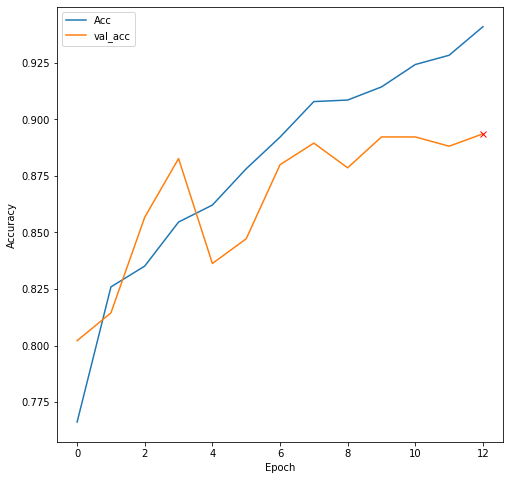

In [0]:
plt.figure(figsize=(8, 8))
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

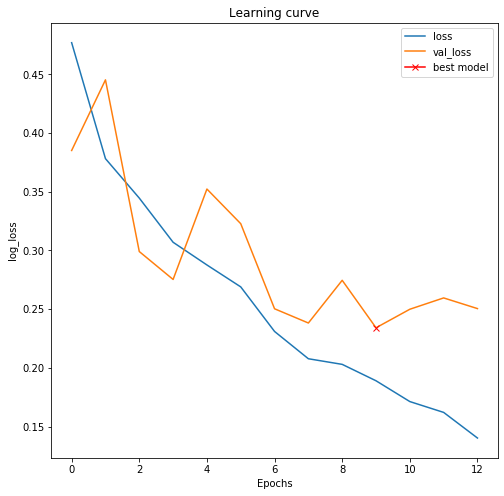

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

So we get the best model with a Training accuracy of ~94% and test accuracy of ~90%

Lets see if we can use transfer learning and achieve some gains.

In [0]:
from keras.applications import DenseNet121
def create_densenet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=input_tensor)
    #base_model.load_weights('/kaggle/working/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='sigmoid', name="Output_Layer")(x)
    model_densenet= Model(input_tensor, output_layer)
    return model_densenet


model_densenet = create_densenet(300, 3, 1)
for layers in model_densenet.layers:
    layers.trainable = True

y=np.array(df_train['diagnosis'])

optimizer=Adam()
model_densenet.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=['accuracy',auc,recall_m, precision_m, f1_m])

gc.collect()

history=model_densenet.fit(x[:3663, :,:,:], 
          y[:3663], 
          epochs=30,
          batch_size=32,
          callbacks=[early_stop, reduce_lr],
          validation_split=0.20, 
          shuffle=True,
          use_multiprocessing=True,
          verbose=1)

predictions=model_densenet.predict(x[:3663, :,:,:])>0.5
cohen_score=cohen_kappa_score(y[:3663], predictions, weights='quadratic')
print("The model finished training with kappa score : "+ str(cohen_score))

Train on 2930 samples, validate on 733 samples
Epoch 1/30
2930/2930 [==============================] - 91s 31ms/step - loss: 0.5811 - acc: 0.8055 - auc: 0.8495 - recall_m: 0.8091 - precision_m: 0.7507 - f1_m: 0.7676 - val_loss: 0.3327 - val_acc: 0.9113 - val_auc: 0.8925 - val_recall_m: 0.8946 - val_precision_m: 0.8767 - val_f1_m: 0.8807
Epoch 2/30
2930/2930 [==============================] - 44s 15ms/step - loss: 0.2922 - acc: 0.8860 - auc: 0.9133 - recall_m: 0.8749 - precision_m: 0.8608 - f1_m: 0.8605 - val_loss: 0.5297 - val_acc: 0.8990 - val_auc: 0.9244 - val_recall_m: 0.9880 - val_precision_m: 0.8013 - val_f1_m: 0.8793
Epoch 3/30
2930/2930 [==============================] - 44s 15ms/step - loss: 0.2606 - acc: 0.8976 - auc: 0.9322 - recall_m: 0.9005 - precision_m: 0.8666 - f1_m: 0.8749 - val_loss: 8.5543 - val_acc: 0.3956 - val_auc: 0.9115 - val_recall_m: 1.0000 - val_precision_m: 0.3924 - val_f1_m: 0.5590

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974

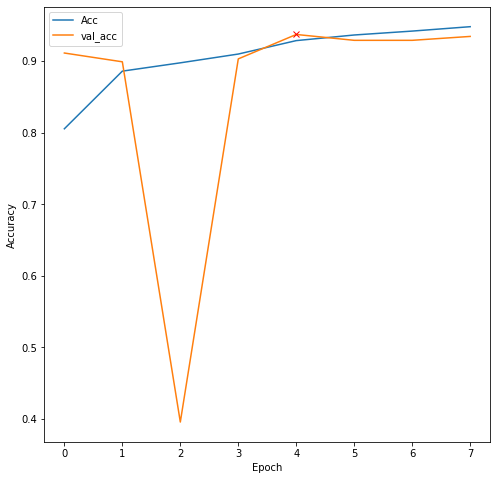

In [0]:
plt.figure(figsize=(8, 8))
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

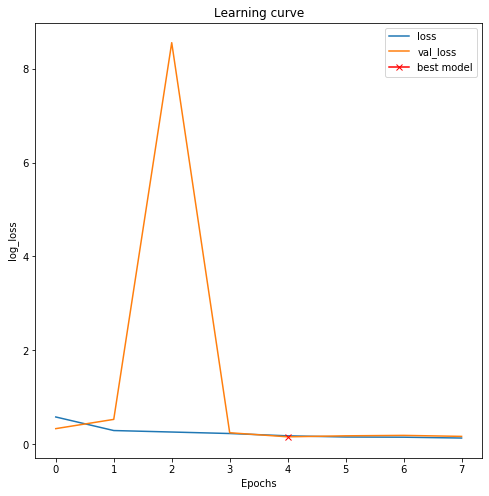

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

![](https://lh3.googleusercontent.com/proxy/ZxNa_rX-4GfWz_eoxeFcCx0Fu7Y2B9GT-GtvCb9RWijSi2T6fdyNK66zZhffQAjo-OWOX5oLA2Bfa32_jB8jsoWDc4uA0nR8dM2qNRkFN4c7qdSVbg3J8Rf9Q16azsuJqA)
</center>




In [0]:
%%capture
! unzip  drive/'My Drive'/train_images/Dest.zip -d drive/'My Drive'/train_images/
! mv drive/'My Drive'/train_images/Dest/Label_1/* drive/'My Drive'/train_images/
! mv drive/'My Drive'/train_images/Dest/Label_2/* drive/'My Drive'/train_images/
! mv drive/'My Drive'/train_images/Dest/Label_3/* drive/'My Drive'/train_images/
! mv drive/'My Drive'/train_images/Dest/Label_4/* drive/'My Drive'/train_images/

In [0]:
%%time
from google.colab import drive
drive.mount('/content/drive')
#! cp -r drive/My\ Drive/train_images .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
CPU times: user 902 ms, sys: 257 ms, total: 1.16 s
Wall time: 23.1 s
